In [1]:
import sys

In [4]:
import tensorflow as tf
print(tf.__version__)

1.15.5


In [5]:
import sys, os, time, glob, joblib, random, itertools, PIL
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn import ensemble
from sklearn import metrics
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import pyod
from pyod.models.copod import COPOD
from pyod.models.cblof import CBLOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
#from pyod.models.deep_svdd import DeepSVDD
import seaborn as sns
import tensorflow as tf

from sbo import soft_brownian_offset
from sbo import gaussian_hyperspheric_offset
import pylab as plt

from IPython import display
from itertools import combinations
#necessary to avoid growth of jupyter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [6]:
PATH='/data/notebook/ganzata_data/'

adfa_competitors=open(PATH+"adfa_competitors.csv", "a")
adfa_competitors.write('dataset, '+
                       'generation technique, '+
                       'classifier, '+
                       'train-test split, '+
                       '# normal in training set, '+
                       '# original attack in training set, '+
                       '# generated attack in training set, '+
                       '# normal in test set, '+
                       '# attacks in test set, '+
                       ' features (columns) - may be 1-hotted, '+
                       ' generated attack is manipulated, '+
                       'tp, tn, fp, fn, accuracy, mcc \n')

adfa_competitors.flush()

In [7]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    if(value_range!=0):
        return starts_from_zero / value_range
    else:
        return starts_from_zero

def compute_TSNE(perplexity,X_data):
    tsne =TSNE(n_components=2, perplexity=perplexity,
     early_exaggeration=12.0, #learning_rate='auto',
     n_iter=1000, n_iter_without_progress=300,
     min_grad_norm=1e-07, metric='euclidean',#init='pca',
     verbose=0, 
     method='barnes_hut', angle=0.5, n_jobs=12).fit_transform(X_data)
    
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    return tx, ty

In [8]:
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

def soft_brownian_offset_1(X, d_min, d_off, n_samples=1, show_progress=False, softness=False,
                         random_state=None):
    """Generates OOD samples using SBO on the input X and returns n_samples number of samples constrained by
    other parameters.
    Args:
        X (:obj:`numpy.array`): In-distribution (ID) data to form OOD samples around. First dimension contains samples
        d_min (float): (Likely) Minimum distance to ID data
        d_off (float): Offset distance used in each iteration
        n_samples(int): Number of samples to return
        show_progress(boolean): Whether to show a tqdm progress bar
        softness(float): Describes softness of minimum distance. Parameter between 0 (hard) and 1 (soft)
        random_state(int): RNG state used for reproducibility
    Returns:
        :obj:`numpy.array`:
            Out of distribution samples of shape (n_samples, X.shape[1])
    """
    if softness == 0:
        softness = False
    if random_state is not None:
        np.random.seed(random_state)
    n_dim = X.shape[1]
    ys = []
    iterator = range(n_samples)
    if show_progress:
        iterator = tqdm(iterator)
    for i in iterator:
        # Sample uniformly from X
        y = X[np.random.choice(len(X))].astype(float)
        # Move out of reach of other points
        skip = False
        while True:
            dist = pairwise_distances(y[:, None].T, X)[0]
            if dist.min() > 0:
                if not softness and dist.min() > d_min:
                    skip = True
                elif softness > 0:
                    p = 1 / (1 + np.exp((-dist.min() + d_min) / softness / d_min * 7))
                    if np.random.uniform() < p:
                        skip = True
                elif not isinstance(softness, bool):
                    raise ValueError("Softness should be float greater zero")
            if skip:
                break
            y += gaussian_hyperspheric_offset(1, n_dim=n_dim)[0] * d_off
        ys.append(np.array(y))
    return np.array(ys)

First, we create the test and train split

In [9]:
ADFANet=pd.read_csv("./datasets/ADFANet_Shuffled_LabelOK.csv")
ADFANet_Y=ADFANet[['label']]
print(ADFANet_Y['label'].unique())
ADFANet_X=ADFANet.drop('label', axis=1, inplace=False)
ADFANet_Y.loc[ADFANet_Y['label']=='normal', 'label']=0
ADFANet_Y.loc[ADFANet_Y['label']!=0, 'label']=1
ADFANet_Y=ADFANet_Y.astype(int)

print(ADFANet_Y['label'].unique())

['1b' 'normal' 'neptune' 'other' 'portsweep' 'mailbomb']
[1 0]


In [10]:
ADFANet_X

,packets,bytes,Duration
0,13,13005,0
1,11,1292,0
2,271,13193,13
3,1,142,0
4,1,160,0
...,...,...,...
132001,1,115,0
132002,1,143,0
132003,1,160,0
132004,1,144,0


In [12]:
ADFANet_train_X, ADFANet_test_X, ADFANet_train_Y, ADFANet_test_Y = train_test_split(ADFANet_X,ADFANet_Y, 
                                                                                    test_size=0.4, 
                                                                                    shuffle=True)

contamination= (np.sum(ADFANet_train_Y.to_numpy(), axis=0)/ADFANet_train_Y.to_numpy().shape[0])[0]

print("train size, test size, contamination in train")
ADFANet_train_X.shape, ADFANet_test_X.shape, contamination

train size, test size, contamination in train


((79203, 3), (52803, 3), 0.3096094844892239)

xgboost in a fully supervised setting

In [13]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X, ADFANet_train_Y)
predicted=xb.predict(ADFANet_test_X)

In [14]:
accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(16418, 36334, 30, 21, 0.9990341457871712, 0.9977479843569788)

In [15]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'xgboost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

... and random forests

In [16]:
clf= RandomForestClassifier(n_estimators=500, 
                                             criterion='gini',
                                             max_depth=None,
                                             min_samples_split=2,
                                             min_samples_leaf=1,
                                             min_weight_fraction_leaf=0.0,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             bootstrap=True,
                                             oob_score=False,
                                             n_jobs=12,
                                             random_state=42,
                                             verbose=0,
                                             warm_start=False,
                                             class_weight=None,
                                             ccp_alpha=0.0,
                                             max_samples=None)


clf.fit(ADFANet_train_X, ADFANet_train_Y)

predicted=clf.predict(ADFANet_test_X)

In [17]:
accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(16425, 36331, 33, 14, 0.9991098990587656, 0.9979252373230881)

In [18]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'Random Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

Isolation Forest (unsupervised)

In [19]:
isol=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X.to_numpy())

In [20]:
predicted=isol.predict(ADFANet_test_X.to_numpy())

In [21]:
Y=ADFANet_test_Y.to_numpy().T[0]
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(6880, 34322, 2042, 9559, 0.7802965740582921, 0.4477621771686692)

In [22]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

COPOD and CBLOF

In [23]:
clf = COPOD(contamination=contamination, n_jobs=12)
clf.fit(ADFANet_train_X.to_numpy())
predicted = clf.predict(ADFANet_test_X.to_numpy())  # outlier labels (0 or 1)
Y=ADFANet_test_Y.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished


(6880, 32757, 3607, 9559, 0.7506581065469765, 0.3706202069658033)

In [24]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'COPOD, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [25]:
clf = CBLOF(contamination=contamination, n_jobs=12) # n_clusters=8
clf.fit(ADFANet_train_X.to_numpy())
predicted = clf.predict(ADFANet_test_X.to_numpy())  # outlier labels (0 or 1)
Y=ADFANet_test_Y.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(14730, 35129, 1235, 1709, 0.944245592106509, 0.8691354669665711)

In [26]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

and one class-SVM

In [27]:
from sklearn.svm import OneClassSVM
svm_clf=OneClassSVM(kernel='rbf',
                    degree=3,
                    gamma='scale',
                    coef0=0.0,
                    tol=0.001,
                    nu=0.5,
                    shrinking=False,
                    cache_size=600,
                    verbose=False,
                    max_iter=-1).fit(ADFANet_train_X.to_numpy())

predicted= svm_clf.predict(ADFANet_test_X.to_numpy())

Y=ADFANet_test_Y.to_numpy().T[0]
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc


(12913, 22473, 13891, 3526, 0.6701513171600099, 0.37372417435807814)

In [28]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'SVM, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

We now test autoencoders from PYOD: AutoEncoder, VAE

In [30]:
clf=AutoEncoder(hidden_neurons=[3, 16, 16, 3], #default=[64, 32, 32, 64]
                hidden_activation='relu', output_activation='sigmoid',
                optimizer='adam', epochs=100, batch_size=1024,
                dropout_rate=0.2, l2_regularizer=0.1,
                validation_size=0.1,
                preprocessing=True,
                verbose=1,
                random_state=None,
                contamination=contamination)

clf.fit(ADFANet_train_X.to_numpy())
predicted = clf.predict(ADFANet_test_X.to_numpy())  # outlier labels (0 or 1)
Y=ADFANet_test_Y.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 12        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12        
_________________________________________________________________
dropout_3 (Dropout)          (None, 3)                 0         
_______________________________________

2023-04-14 18:29:15.966053: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-04-14 18:29:16.133953: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3900000000 Hz
2023-04-14 18:29:16.136472: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5633bd894170 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-14 18:29:16.136510: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version



Train on 71282 samples, validate on 7921 samples
Epoch 1/100
71282/71282 [==============================] - 1s 14us/step - loss: 87.0145 - val_loss: 77.4468
Epoch 2/100
71282/71282 [==============================] - 0s 6us/step - loss: 75.4790 - val_loss: 68.5476
Epoch 3/100
71282/71282 [==============================] - 0s 6us/step - loss: 67.3681 - val_loss: 61.7245
Epoch 4/100
71282/71282 [==============================] - 0s 6us/step - loss: 60.9005 - val_loss: 56.0354
Epoch 5/100
71282/71282 [==============================] - 0s 6us/step - loss: 55.4255 - val_loss: 51.1212
Epoch 6/100
71282/71282 [==============================] - 0s 6us/step - loss: 50.6417 - val_loss: 46.8033
Epoch 7/100
71282/71282 [==============================] - 0s 6us/step - loss: 46.4450 - val_loss: 42.9687
Epoch 8/100
71282/71282 [==============================] - 0s 6us/step - loss: 42.7416 - val_loss: 39.5667
Epoch 9/100
71282/71282 [==============================] - 0s 6us/step - loss: 39.4314 - val_

(12820, 34470, 1894, 3619, 0.8955930534249948, 0.7516254930524571)

In [31]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'AutoEncoder, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [32]:
clf=VAE(encoder_neurons=[3, 64, 32], #(default=[128, 64, 32])
        decoder_neurons=[32, 64, 3], #(default=[32, 64, 128])
        latent_dim=2, hidden_activation='relu', output_activation='sigmoid', 
        optimizer='adam', epochs=60, batch_size=1024, 
        dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, 
        preprocessing=True, verbose=1, random_state=None,
        contamination=contamination,
        gamma=1.0, capacity=0.8)

clf.fit(ADFANet_train_X.to_numpy())
predicted = clf.predict(ADFANet_test_X.to_numpy())  # outlier labels (0 or 1)
Y=ADFANet_test_Y.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 3)            12          input_1[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 3)            12          dense_8[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 3)            0           dense_9[0][0]                    
____________________________________________________________________________________________

(12967, 34315, 2049, 3472, 0.895441546881806, 0.7517994168694783)

In [33]:
normal_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][0]
original_attack_in_training_set=np.unique(ADFANet_train_Y, return_counts=True)[1][1]
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'all known, '+
                       'VAE, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

**Now there are no attacks at all in the training set.**

contamination is set to 0 (or default if 0 is not accepted), attacks are removed from the training set

In [34]:
contamination=0.0
trainingX_Y=pd.concat([ADFANet_train_X, ADFANet_train_Y], axis=1)
ADFANet_train_X_no_attack=trainingX_Y[trainingX_Y.label == 0]

In [35]:
ADFANet_train_X_no_attack=ADFANet_train_X_no_attack.drop(['label'], axis=1)
ADFANet_train_X_no_attack.shape

(54681, 3)

In [36]:
#test set with all attack
missing_attacks=trainingX_Y[trainingX_Y['label']!=0]
missing_attacks=missing_attacks.drop(['label'], axis=1)
frames=[ADFANet_test_X, missing_attacks]
ADFANet_test_X=pd.concat(frames).to_numpy()
ADFANet_test_Y=np.vstack((ADFANet_test_Y.to_numpy(), np.ones((missing_attacks.to_numpy().shape[0], 1))))

In [37]:
ADFANet_test_Y.shape,ADFANet_test_X.shape

((77325, 1), (77325, 3))

In [38]:
ADFANet_train_X_no_attack

,packets,bytes,Duration
87454,1,160,0
4835,1,117,0
56769,1,160,0
85224,1,160,0
36920,1,160,0
...,...,...,...
115409,1,120,0
4103,1,160,0
85491,1,162,0
81045,1,160,0


In [1]:
np.save('/home/notebook/adfa/train_X_no_attack', ADFANet_train_X_no_attack )
np.save('/home/notebook/adfa/test_X', ADFANet_test_X)
np.save('/home/notebook/adfa/test_Y', ADFANet_test_Y )

NameError: name 'np' is not defined

In [40]:
isol=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     #contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X_no_attack.to_numpy())

predicted=isol.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40961, 34253, 2111, 0, 0.9726996443582283, 0.9464577657425541)

In [41]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'no attacks at all, '+
                       'IsolationForest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [42]:
svm_clf=OneClassSVM(kernel='rbf',
                    degree=3,
                    gamma='scale',
                    coef0=0.0,
                    tol=0.001,
                    nu=0.5,
                    shrinking=False,
                    cache_size=600,
                    verbose=False,
                    max_iter=-1).fit(ADFANet_train_X.to_numpy())

predicted= svm_clf.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(32246, 22473, 13891, 8715, 0.7076495311994827, 0.41229947464743977)

In [43]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'no attacks at all, '+
                       'SVM, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [44]:
clf = COPOD(n_jobs=12)#contamination=contamination,
clf.fit(ADFANet_train_X_no_attack.to_numpy())
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished


(17148, 32819, 3545, 23813, 0.6461946330423537, 0.36207114691386644)

In [45]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'no attacks at all, '+
                       'COPOD, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [46]:
clf = CBLOF(n_jobs=12) # contamination=contamination, n_clusters=8
clf.fit(ADFANet_train_X_no_attack.to_numpy())
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40669, 35056, 1308, 292, 0.9793081150986097, 0.9587387288335739)

In [47]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'no attacks at all, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [49]:
clf=AutoEncoder(hidden_neurons=[3, 16, 16, 3], #default=[64, 32, 32, 64]
                hidden_activation='relu', output_activation='sigmoid',
                optimizer='adam', epochs=100, batch_size=1024,
                dropout_rate=0.2, l2_regularizer=0.1,
                validation_size=0.1,
                preprocessing=True,
                verbose=1,
                random_state=None)#,
                #contamination=contamination

clf.fit(ADFANet_train_X_no_attack.to_numpy())
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 3)                 12        
_________________________________________________________________
dropout_13 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 12        
_________________________________________________________________
dropout_14 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 12        
_________________________________________________________________
dropout_15 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)               

(35475, 34367, 1997, 5486, 0.9032266408018106, 0.810100200276002)

In [50]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'no attacks at all, '+
                       'AutoEncoder, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [51]:
clf=VAE(encoder_neurons=[3, 64, 32], #(default=[128, 64, 32])
        decoder_neurons=[32, 64, 3], #(default=[32, 64, 128])
        latent_dim=2, hidden_activation='relu', output_activation='sigmoid', 
        optimizer='adam', epochs=60, batch_size=1024, 
        dropout_rate=0.2, l2_regularizer=0.1, validation_size=0.1, 
        preprocessing=True, verbose=1, random_state=None,
        #contamination=contamination,
        gamma=1.0, capacity=0.8)

clf.fit(ADFANet_train_X_no_attack.to_numpy())
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 3)            12          input_3[0][0]                    
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 3)            12          dense_26[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 3)            0           dense_27[0][0]                   
____________________________________________________________________________________________

(39996, 32805, 3559, 965, 0.9414936954413191, 0.8841229719180358)

In [52]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
adfa_competitors.write('ADFANet, '+
                       'no attacks at all, '+
                       'VAE, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       '0, '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO GENERATED ATTACK, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

Soft-Brownian Offset https://github.com/flxai/soft-brownian-offset


Moller, Felix, et al. "Out-of-distribution detection and generation using soft brownian offset sampling and autoencoders." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.<

In [53]:
def plot_mindist(X, y, ax=plt):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(y.shape) == 1:
        y = y[:, None]
    ax.hist(pairwise_distances(y, X).min(axis=1), bins=len(y) // 10)
    ax.set_xlabel("Minimum distance from ood to id")
    ax.set_ylabel("Count")

def plot_data_mindist(X, y):
    fig, ax = plt.subplots(1, 2)
    plot_data(X, y, ax=ax[0])
    plot_mindist(X, y, ax=ax[1])
    plt.show()
    
def plot_data(X, y, ax=plt):
    ax.scatter(X[:, 0], X[:, 1], marker='x', s=20, label='ID', alpha=alpha, c=[c[-1]])
    ax.scatter(y[:, 0], y[:, 1], marker='+', label='SBO', alpha=alpha, c=[c[-6]])

#### method 1: gaussian hyperspheric offset.

In [179]:
#dataset features
n_dim=3

#data to generate for each couple d_min, softness
new_data=10

#number of combinations comb_gaussian_hyperspheric_offset and soft_brownian_offset
n_samples=50

mu=np.linspace(.001, .9, n_samples)
std=np.linspace(.001, .9, n_samples)

d_min_vector = np.linspace(.6, 1.0, n_samples)
softness_vector = np.linspace(0.4, 1.0, n_samples)
d_off_coefficient= .3


In [180]:
comb_gaussian_hyperspheric_offset=list(itertools.product(mu, std))
soft_brownian_offset=list(itertools.product(d_min_vector, softness_vector))

In [182]:
len(list(itertools.product(d_min_vector, softness_vector)))

2500

In [56]:
ADFANet_train_X_no_attack=ADFANet_train_X_no_attack.to_numpy()

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(ADFANet_train_X_no_attack)
train_normalized=scaler.transform(ADFANet_train_X_no_attack)

In [58]:
first=0
for mu, std in comb_gaussian_hyperspheric_offset:
    if (first==0):
        X_ood = (gaussian_hyperspheric_offset(n_samples=new_data,
                                      mu=mu,
                                      std=std,
                                      n_dim=n_dim) + train_normalized.mean()) * train_normalized.std()
        first=1
    else:
        X_tmp = (gaussian_hyperspheric_offset(n_samples=new_data,
                                      mu=mu,
                                      std=std,
                                      n_dim=n_dim) + train_normalized.mean()) * train_normalized.std()
        X_ood=np.vstack((X_ood,X_tmp))


In [59]:
X_ood

array([[ 0.00012894,  0.00012203,  0.00012102],
       [ 0.00012358,  0.00012304,  0.0001242 ],
       [ 0.00012357,  0.00012543,  0.00012099],
       ...,
       [ 0.0035081 , -0.01004112, -0.01875419],
       [ 0.02082941,  0.00202431, -0.00013194],
       [ 0.00709993,  0.01931402, -0.0314595 ]])

#### metodo 2: soft_brownian_offset

In [60]:
first=0

for d_min, softness in soft_brownian_offset:
    if (first==0):
        X_ood=soft_brownian_offset_1(ADFANet_train_X_no_attack,d_min=d_min,
                                   d_off=d_min*d_off_coefficient,
                                   n_samples=new_data,
                                   softness=softness, show_progress=False)
        first=1
    else:
        X_tmp = soft_brownian_offset_1(ADFANet_train_X_no_attack,
                                     d_min=d_min,d_off=d_min*d_off_coefficient,
                                     n_samples=new_data,
                                     softness=softness, show_progress=False)
        X_ood=np.vstack((X_ood,X_tmp))

In [61]:
ADFANet_train_X_no_attack.shape, X_ood.shape

((54681, 3), (25000, 3))

provo a forzare una conversione a intero

In [62]:
X_ood=np.round(X_ood).astype(int)
X_ood

array([[  1, 137,  -1],
       [  2, 136,   0],
       [  1, 159,   0],
       ...,
       [  0, 118,   0],
       [  0, 161,   0],
       [  1, 140,   1]])

We apply a small trick, that has actually very little or no relevance. We remove OOD generated data that is identical or too similar to the normal data. This should actually not happen, because we are generating specifically OOD data. 

However, some data is removed and things get maybe a little (very little) better.

In [63]:
#remove identical elements from the generated attacks
a= ADFANet_train_X_no_attack
b=X_ood
res = (b[:, None] == a).all(-1).any(-1)
c=b[np.array(res==False)]
X_ood=c
ADFANet_train_X_no_attack.shape, X_ood.shape

((54681, 3), (23716, 3))

In [64]:
#remove elements that are very close according to proximity evaluation
#proximity evaluation is multidimensional euclidean distance
#but this is uselesss for soft brownian offset
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [68]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [69]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(10348, 36333, 31, 30613, 0.6036986744261235, 0.3686369884120853)

In [70]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'soft brownian offset, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' rounded, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [71]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > c.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(c.shape[0], size=total)
attacks=c[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (10936, 3))

In [72]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40961, 34402, 1962, 0, 0.9746265761396702, 0.9501589475507054)

In [73]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'soft brownian offset, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' rounded, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [74]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40669, 30453, 5911, 292, 0.9197801487229227, 0.8467979808213066)

In [75]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'soft brownian offset, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' rounded, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [76]:
np.save('/home/notebook/attack_generation/saved_attacks_generated/adfa/soft_brownian_offset.npy', X_ood)

#### We visualize the data

For completeness, we visualize the attack data generated and used in the training set (and the normal data).

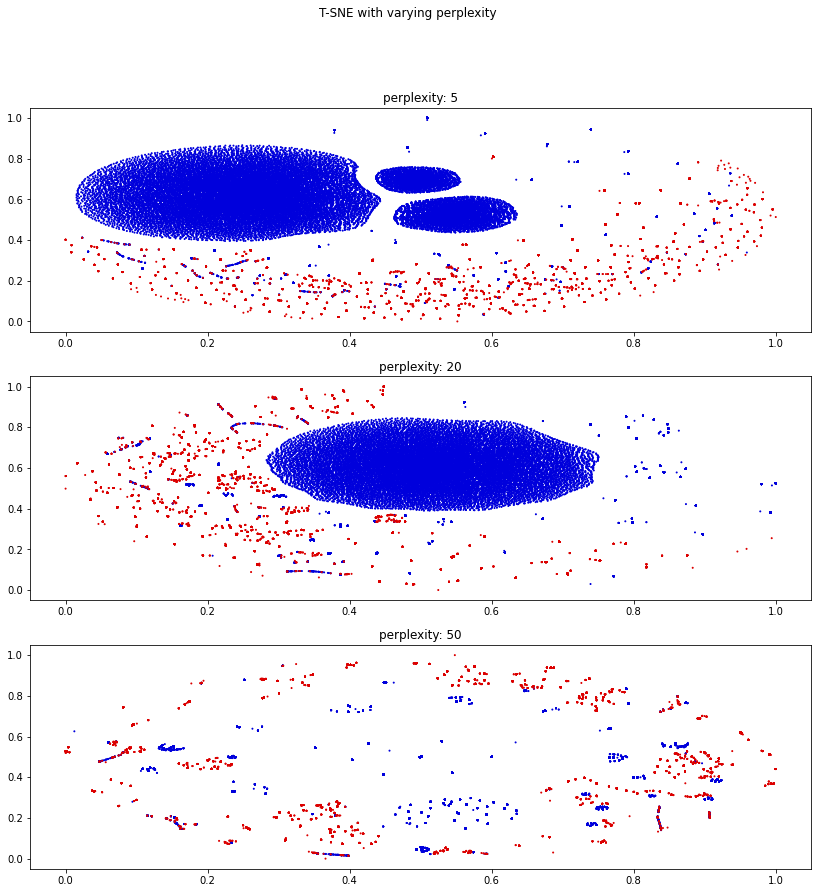

In [77]:
TEST_SIZE= ADFANet_train_X__no_attacks_augmented.shape[0] 
X=ADFANet_train_X__no_attacks_augmented[0:TEST_SIZE]
Y=ADFANet_train_Y__no_attacks_augmented[0:TEST_SIZE]
perplexity=[5, 20, 50]

# initialize a matplotlib plot
fig, (ax0, ax1, ax2) = plt.subplots(3)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, [0/255.0, 0/255.0, 220/255.0], [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

# finally, show the plot
plt.show()

### now we use GAN for tabular data

We start with CTGAN


The possible usage with GAN is twofold: 
- if we have attacks and normal, we can try to generate both attacks and normal, and see how the supervised and unsupervised are behaving with the enriched data set. Or, we can try to generate only attacks, to balance the dataset. In any case, it is very useful if the training data is insufficient.
- if we have only normal, we can try to generate attacks. However, the obvious risk is that we end-up generating normal data, and this may be not useful at all.

In [78]:
#!conda  install  --yes --prefix {sys.prefix} -c conda-forge ctgan

In [79]:
import ctgan
from ctgan.demo import load_demo
from ctgan.synthesizers.ctgan import CTGAN
pd.set_option('display.max_colwidth', None)
MKL_NUM_THREADS=6
OMP_NUM_THREADS=6
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#from sklearn.utils.testing import ignore_warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [80]:
discrete_columns = []

In [81]:
ctgan = CTGAN(epochs=5, verbose=True)
ctgan.fit(ADFANet_train_X_no_attack, discrete_columns)

# Create synthetic data
X_ood = ctgan.sample(50000)

Epoch 1, Loss G: -1.1889,Loss D:  0.0428
Epoch 2, Loss G: -0.4759,Loss D: -0.0794
Epoch 3, Loss G:  0.2357,Loss D: -0.1457
Epoch 4, Loss G: -1.4061,Loss D:  0.0175
Epoch 5, Loss G: -0.2053,Loss D: -0.0454


In [82]:
np.save('/home/notebook/CTGAN.npy', X_ood)

In [83]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [84]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(596, 34113, 2251, 40365, 0.4488716456514711, -0.1255008570223216)

In [85]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'CTGAN, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [86]:
X_ood=X_ood
X_ood.dtype

dtype('int64')

In [87]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [88]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40961, 32290, 4074, 0, 0.9473132880698351, 0.898686855892456)

In [89]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'CTGAN, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [90]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40669, 30425, 5939, 292, 0.9194180407371484, 0.8461439333534232)

In [91]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'CTGAN, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

Now we apply improvements:
- remove identical elements (are none; no effect)
- reduce to int (CHANGING SOMETHJING ON ISOLATION FOREST, BUT NOT STABLE)
- remove too close data

In [92]:
X_ood.shape

(50000, 3)

In [93]:
X_ood=X_ood
ADFANet_train_X_no_attack=ADFANet_train_X_no_attack

In [94]:
#remove identical elements from the generated attacks
a= ADFANet_train_X_no_attack
b=X_ood
res = (b[:, None] == a).all(-1).any(-1)
c=b[np.array(res==False)]
X_ood=c
ADFANet_train_X_no_attack.shape, X_ood.shape

((54681, 3), (32637, 3))

In [95]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((X_ood.shape[0],1))))

ADFANet_train_X__no_attacks_augmented.shape, X_ood.shape, ADFANet_train_X_no_attack.shape

((87318, 3), (32637, 3), (54681, 3))

In [96]:
#remove elements that are very close according to proximity evaluation
#proximity evaluation is multidimensional euclidean distance
#but this is uselesss for soft brownian offset
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [97]:
b=X_ood
a=ADFANet_train_X_no_attack
a_length=ADFANet_train_X_no_attack.shape[0]
b_length=X_ood.shape[0]
ab=np.vstack((a,b))
abx, aby=compute_TSNE(5, ab)

In [98]:
ax=abx[:a_length]
ay=aby[:a_length]
bx=aby[a_length:]
by=aby[a_length:]

In [99]:
a_tsne=np.array((ax, ay)).T
b_tsne=np.array((bx, by)).T
res=np.zeros((b_tsne.shape[0],))
tmp=np.zeros(np.shape(a_tsne))
for i in range(0, b_tsne.shape[0]):
    if (i%5000 ==0):
        print(i)
    #TSNE 5 e distanza 0.001 sembrava OK come configurazione
    res[i]=(euclidean_distances(a_tsne, [b_tsne[i]])< 0.001).all(-1).any(-1)

c=b[np.array(res==False)]
# c is the new X_ood
c.shape

0
5000
10000
15000
20000
25000
30000


(29488, 3)

In [100]:
X_ood=c
X_ood.shape

(29488, 3)

In [101]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [102]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(595, 36345, 19, 40366, 0.4777238926608471, 0.07874903474174452)

In [103]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'CTGAN, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' attacks too close to normal are removed, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [104]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (10936, 3))

In [105]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y#.to_numpy().T[0]
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40961, 33029, 3335, 0, 0.9568703524086647, 0.9164629409524851)

In [106]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'CTGAN, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' attacks too close to normal are removed, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [107]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40669, 30454, 5910, 292, 0.9197930811509861, 0.8468213448580959)

In [108]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'CTGAN, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' attacks too close to normal are removed, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

We visualize the generated data and the normal (original) data

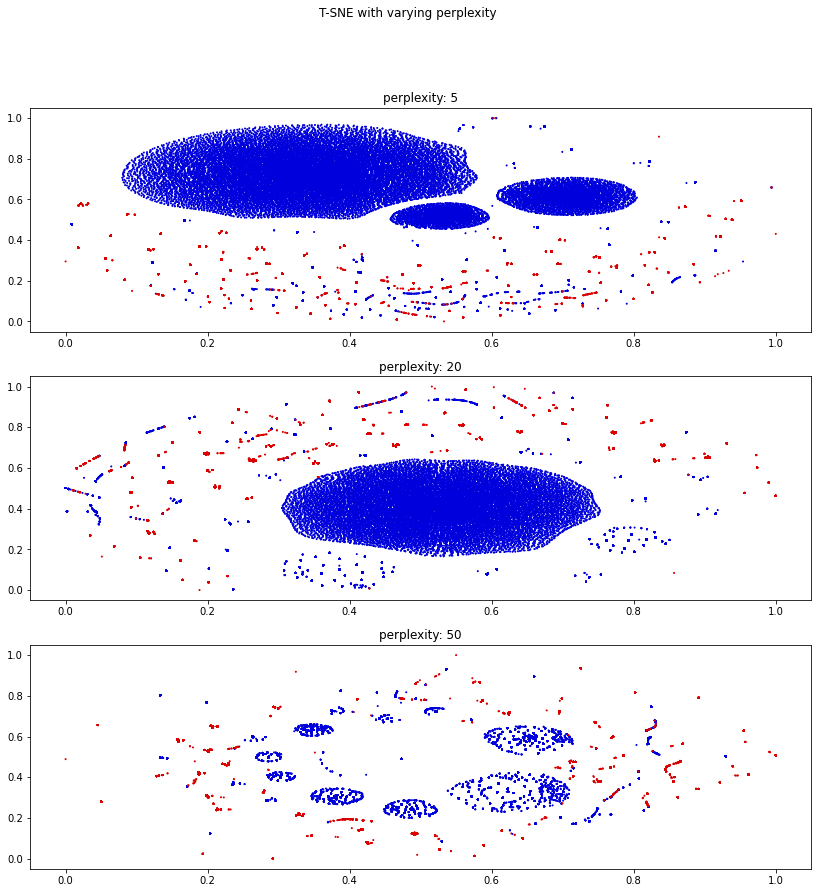

In [109]:
SIZE= ADFANet_train_X__no_attacks_augmented.shape[0]
X=ADFANet_train_X__no_attacks_augmented[0:SIZE]
Y=ADFANet_train_Y__no_attacks_augmented[0:SIZE]
perplexity=[5, 20, 50]

# initialize a matplotlib plot
fig, (ax0, ax1, ax2) = plt.subplots(3)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, 
                 [0/255.0, 0/255.0, 220/255.0], 
                 [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

# finally, show the plot
plt.show()

### ALAD

In [2]:
generated_attacks=np.load('/home/notebook/eGAN/Efficient-GAN-Anomaly-Detection/data/adfa_generated_attacks.npy')

NameError: name 'np' is not defined

First, we use the generated attacks without any kind of optimization or improvement of data quality.

In [111]:
X_ood=generated_attacks
X_ood.shape

(50000, 3)

In [112]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [113]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 36364, 0, 40961, 0.4702748140963466, 0.0)

In [114]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ALAD (eGAN), '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [115]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (10936, 3))

In [116]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40961, 34239, 2125, 0, 0.972518590365341, 0.9461105782437887)

In [117]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ALAD (eGAN), '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [118]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(16310, 35364, 1000, 24651, 0.6682702877465244, 0.4438603995125101)

In [119]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ALAD (eGAN), '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

Now we apply improvements:
- remove identical elements (are none; no effect)
- reduce to int (CHANGING SOMETHJING ON ISOLATION FOREST, BUT NOT STABLE)
- remove too close data

In [120]:
#convert to int
#X_ood=(np.rint(X_ood)).astype(int)

In [121]:
#remove identical elements from the generated attacks
a= ADFANet_train_X_no_attack
b=X_ood
res = (b[:, None] == a).all(-1).any(-1)
c=b[np.array(res==False)]
X_ood=c
a.shape, X_ood.shape

((54681, 3), (50000, 3))

In [122]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((X_ood.shape[0],1))))

ADFANet_train_X__no_attacks_augmented.shape, X_ood.shape, ADFANet_train_X_no_attack.shape

((104681, 3), (50000, 3), (54681, 3))

In [123]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [124]:
b=X_ood
a=ADFANet_train_X_no_attack
a_length=ADFANet_train_X_no_attack.shape[0]
b_length=X_ood.shape[0]
ab=np.vstack((a,b))
abx, aby=compute_TSNE(50, ab)

In [125]:
ax=abx[:a_length]
ay=aby[:a_length]
bx=aby[a_length:]
by=aby[a_length:]

In [126]:
a_tsne=np.array((ax, ay)).T
b_tsne=np.array((bx, by)).T
res=np.zeros((b_tsne.shape[0],))
tmp=np.zeros(np.shape(a_tsne))
for i in range(0, b_tsne.shape[0]):
    if (i%5000 ==0):
        print(i)
    #TSNE 5 e distanza 0.001 sembrava OK come configurazione
    res[i]=(euclidean_distances(a_tsne, [b_tsne[i]])< 0.01).all(-1).any(-1)

c=b[np.array(res==False)]
# c is the new X_ood
c.shape

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


(50000, 3)

In [127]:
X_ood=c
X_ood.shape

(50000, 3)

In [128]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [129]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(0, 36364, 0, 40961, 0.4702748140963466, 0.0)

In [130]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ALAD (eGAN), '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'remove close elements, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [131]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination, attacks.shape

(0.16666666666666669, (10936, 3))

In [132]:
isol_1=IsolationForest(n_estimators=800,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y#.to_numpy().T[0]
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40961, 34239, 2125, 0, 0.972518590365341, 0.9461105782437887)

In [133]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ALAD (eGAN), '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'remove close elements, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [134]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(16309, 35364, 1000, 24652, 0.6682573553184611, 0.4438402895045992)

In [135]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ALAD (eGAN), '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'remove close elements, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

We visualize the generated data and the normal (original) data

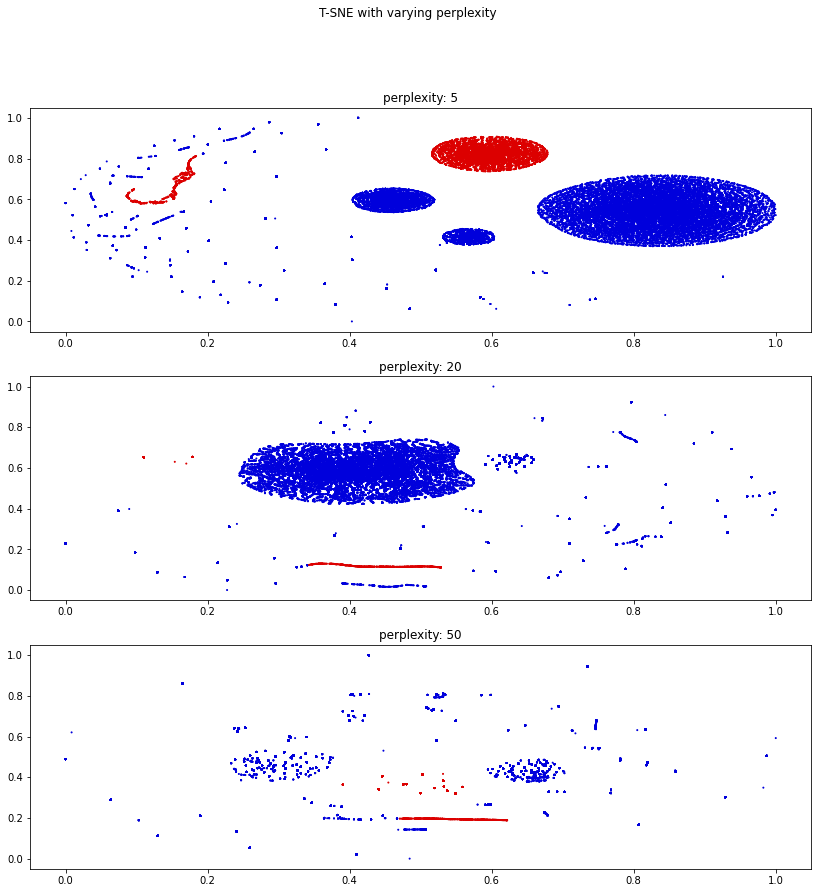

In [136]:
SIZE= ADFANet_train_X__no_attacks_augmented.shape[0]
X=ADFANet_train_X__no_attacks_augmented[0:SIZE]
Y=ADFANet_train_Y__no_attacks_augmented[0:SIZE]
perplexity=[5, 20, 50]

# initialize a matplotlib plot
fig, (ax0, ax1, ax2) = plt.subplots(3)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, 
                 [0/255.0, 0/255.0, 220/255.0], 
                 [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

# finally, show the plot
plt.show()

### Gaussian Copulas

In [137]:
train_X_no_attack=pd.DataFrame(ADFANet_train_X_no_attack, columns=['a','b','c'])
#train_X_no_attack.head()

In [138]:
train_X_no_attack.dtypes

a    int64
b    int64
c    int64
dtype: object

In [139]:
from copulas.multivariate import GaussianMultivariate

dist = GaussianMultivariate()
dist.fit(train_X_no_attack)

In [140]:
X_ood = dist.sample(50000)

In [141]:
X_ood=X_ood.to_numpy()
from numpy import inf
X_ood=np.nan_to_num(X_ood, copy=True, nan=0.0, posinf=0, neginf=0)

In [3]:
np.save('/home/notebook/gaussian_copulas.npy', X_ood)

NameError: name 'np' is not defined

In [143]:
X_ood=np.round(X_ood).astype(int)

In [144]:
from copulas.visualization import compare_3d
#compare_3d(train_X_no_attack, pd.DataFrame(X_ood))

In [145]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, X_ood))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((X_ood.shape[0], 1))))

In [146]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(7324, 36354, 10, 33637, 0.5648625929518267, 0.3041157289204231)

In [147]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'Gaussian Copulas, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'round integer and remove inf, nan, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [148]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > X_ood.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(X_ood.shape[0], size=total)
attacks=X_ood[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [149]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40358, 34385, 1979, 603, 0.9666084707403815, 0.9334355581850351)

In [150]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'Gaussian Copulas, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'round integer and remove inf, nan, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [151]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40334, 35059, 1305, 627, 0.9750145489815712, 0.949946758627116)

In [152]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'Gaussian Copulas, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'round integer and remove inf, nan, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

We remove identical elements and elements too close to the normal ones.

In [153]:
a= ADFANet_train_X_no_attack
b=X_ood
res = (b[:, None] == a).all(-1).any(-1)
c=b[np.array(res==False)]
X_ood=c
ADFANet_train_X_no_attack.shape, X_ood.shape

((54681, 3), (49909, 3))

In [154]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [155]:
b=X_ood
a=ADFANet_train_X_no_attack
a_length=ADFANet_train_X_no_attack.shape[0]
b_length=X_ood.shape[0]

ab=np.vstack((a,b))

abx, aby=compute_TSNE(50, ab)#prima lo ho testato con 5

In [156]:
ax=abx[:a_length]
ay=aby[:a_length]
bx=aby[a_length:]
by=aby[a_length:]

In [157]:
a_tsne=np.array((ax, ay)).T
b_tsne=np.array((bx, by)).T
res=np.zeros((b_tsne.shape[0],))
tmp=np.zeros(np.shape(a_tsne))
for i in range(0, b_tsne.shape[0]):
    if (i%5000 ==0):
        print(i)
    #TSNE 5 e distanza 0.001 sembrava OK come configurazione
    res[i]=(euclidean_distances(a_tsne, [b_tsne[i]])< 0.02).all(-1).any(-1)

c=b[np.array(res==False)]
# c is the new X_ood
c.shape

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


(25608, 3)

In [158]:
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, c))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0],1)),
                                                 np.ones((c.shape[0], 1))))

In [159]:
xb=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False )
xb.fit(ADFANet_train_X__no_attacks_augmented, ADFANet_train_Y__no_attacks_augmented)
predicted=xb.predict(ADFANet_test_X)

accuracy=accuracy_score(ADFANet_test_Y, predicted)
tn, fp, fn, tp = confusion_matrix(ADFANet_test_Y, predicted).ravel()
mcc=matthews_corrcoef(ADFANet_test_Y, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(3883, 36355, 9, 37078, 0.5203750404138378, 0.21584925228076074)

In [160]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'Gaussian Copulas, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'round integer and remove inf, nan, similar values '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [161]:
contamination=0.2

total=int(ADFANet_train_X_no_attack.shape[0]*contamination)
if(total > c.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)

idx = np.random.randint(c.shape[0], size=total)
attacks=c[idx,:]
ADFANet_train_X__no_attacks_augmented=np.vstack((ADFANet_train_X_no_attack, attacks))
ADFANet_train_Y__no_attacks_augmented=np.vstack((np.zeros((ADFANet_train_X_no_attack.shape[0], 1)),
                                                 np.ones((attacks.shape[0],1))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [162]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(ADFANet_train_X__no_attacks_augmented)

predicted=isol_1.predict(ADFANet_test_X)

Y=ADFANet_test_Y
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(16364, 34422, 1942, 24597, 0.6567862916262528, 0.4063749311685942)

In [163]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'Gaussian Copulas, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'round integer and remove inf, nan, similar values '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [164]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(ADFANet_train_X__no_attacks_augmented)
predicted = clf.predict(ADFANet_test_X)  # outlier labels (0 or 1)
Y=ADFANet_test_Y#.to_numpy().T[0]
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(40334, 35059, 1305, 627, 0.9750145489815712, 0.949946758627116)

In [165]:
normal_in_training_set=np.unique(ADFANet_train_X_no_attack.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][0]
attacks_in_test_set=np.unique(ADFANet_test_Y, return_counts=True)[1][1]
generated_attacks=X_ood.shape[0]
adfa_competitors.write('ADFANet, '+
                       'Gaussian Copulas, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(generated_attacks)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       'round integer and remove inf, nan, similar values '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

### ARN - Adversarial Regularized Reconstruction for Anomaly Detection and Generation

In [166]:
generated_attacks=np.load('/home/notebook/attack_generation/saved_attacks_generated/adfa/arn.npy')

In [167]:
x_train=np.load('/home/notebook/attack_generation/saved_attacks_generated/adfa/ARN_x_train.npy')
y_train=np.load('/home/notebook/attack_generation/saved_attacks_generated/adfa/ARN_y_train.npy')
x_test=np.load('/home/notebook/attack_generation/saved_attacks_generated/adfa/ARN_x_test.npy')
y_test=np.load('/home/notebook/attack_generation/saved_attacks_generated/adfa/ARN_y_test.npy')

In [168]:
x_train.shape, generated_attacks.shape

((54627, 1119), (54272, 1119))

In [169]:
x_train_augmented=np.vstack((x_train,generated_attacks))

y_train_augmented=np.hstack((y_train,
                             np.ones(generated_attacks.shape[0],)))

In [170]:
xb=xgb.XGBClassifier(objective='binary:logistic', 
                     use_label_encoder=False )
xb.fit(x_train_augmented, 
       y_train_augmented)

predicted=xb.predict(x_test)

accuracy=accuracy_score(y_test, predicted)
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
mcc=matthews_corrcoef(y_test, predicted)
print("tp, tn, fp, fn, accuracy, mcc:")
tp, tn, fp, fn, accuracy, mcc

tp, tn, fp, fn, accuracy, mcc:


(62, 36418, 0, 40899, 0.4714457410925445, 0.026701220789747248)

In [171]:
normal_in_training_set=np.unique(x_train.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(y_test, return_counts=True)[1][0]
attacks_in_test_set=np.unique(y_test, return_counts=True)[1][1]
ga=generated_attacks.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ARN, '+
                       'XGBoost, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(ga)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [172]:
contamination=0.2

total=int(x_train.shape[0]*contamination)
if(total > generated_attacks.shape[0]):
    print("contamination is larger than the available attacks")
    sys.exit(0)
    
np.random.shuffle(generated_attacks)

idx = np.random.randint(generated_attacks.shape[0], size=total)
attacks=generated_attacks[idx,:]
x_train_augmented=np.vstack((x_train, attacks))
y_train_augmented=np.hstack((y_train,np.ones((attacks.shape[0],))))
                                                 
contamination=contamination/(1+contamination)
                                                 
contamination

0.16666666666666669

In [173]:
isol_1=IsolationForest(n_estimators=300,
                     max_samples='auto',
                     contamination=contamination,
                     max_features=1.0,
                     bootstrap=False,
                     n_jobs=12,warm_start=False).fit(x_train_augmented)

predicted=isol_1.predict(x_test)

Y=y_test
predicted=np.where(predicted==-1, 1, 0)
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(17148, 34439, 1979, 23813, 0.6666795900696572, 0.42152629574986156)

In [174]:
normal_in_training_set=np.unique(x_train.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(y_test, return_counts=True)[1][0]
attacks_in_test_set=np.unique(y_test, return_counts=True)[1][1]
ga=generated_attacks.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ARN, '+
                       'Isolation Forest, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(ga)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

In [175]:
clf = CBLOF(n_jobs=12, contamination=contamination)#, n_clusters=8
clf.fit(x_train_augmented)
predicted = clf.predict(x_test)  # outlier labels (0 or 1)
Y=y_test
accuracy=accuracy_score(Y, predicted)
mcc=matthews_corrcoef(Y, predicted)
tn, fp, fn, tp= confusion_matrix(Y, predicted).ravel()
tp, tn, fp, fn, accuracy, mcc

(17145, 34440, 1978, 23816, 0.6666537432636762, 0.42150292930492844)

In [176]:
normal_in_training_set=np.unique(x_train.shape[0])
original_attack_in_training_set=0
normal_in_test_set=np.unique(y_test, return_counts=True)[1][0]
attacks_in_test_set=np.unique(y_test, return_counts=True)[1][1]
ga=generated_attacks.shape[0]
adfa_competitors.write('ADFANet, '+
                       'ARN, '+
                       'CBLOF, '+
                       '0.6--0.4, '+
                       str(normal_in_training_set)+', '+
                       str(original_attack_in_training_set)+', '+
                       str(ga)+', '+
                       str(normal_in_test_set)+', '+
                       str(attacks_in_test_set)+', '+
                       str(ADFANet_test_X.shape[1])+', '+
                       ' NO AUGMENTATION, '+
                       '{}, {}, {}, {}, {:3f}, {:3f} \n'.format(tp, tn, fp, fn, accuracy, mcc))
adfa_competitors.flush()

## Data visualization: original data
We visualize with T-SNE the distribution of data. Remind to configure the TEST_SIZE, large TEST_SIZE may take too much tim. Reference is to: "L. Maaten, G. Hinton, Visualizing data using t-SNE, J. Mach. Learn. Res. 9 (2008) 2579–2605"

#### Original normal and original attack data in ADFANet

First, we plot ADFANet, as is: normal and attack data in the test set.

In [177]:
TEST_SIZE= ADFANet_test_X.shape[0] #ADFANet_test_X.shape[0] 
X=ADFANet_test_X[0:TEST_SIZE]
Y=ADFANet_test_Y[0:TEST_SIZE]
perplexity=[5, 20, 50, 100, 200]

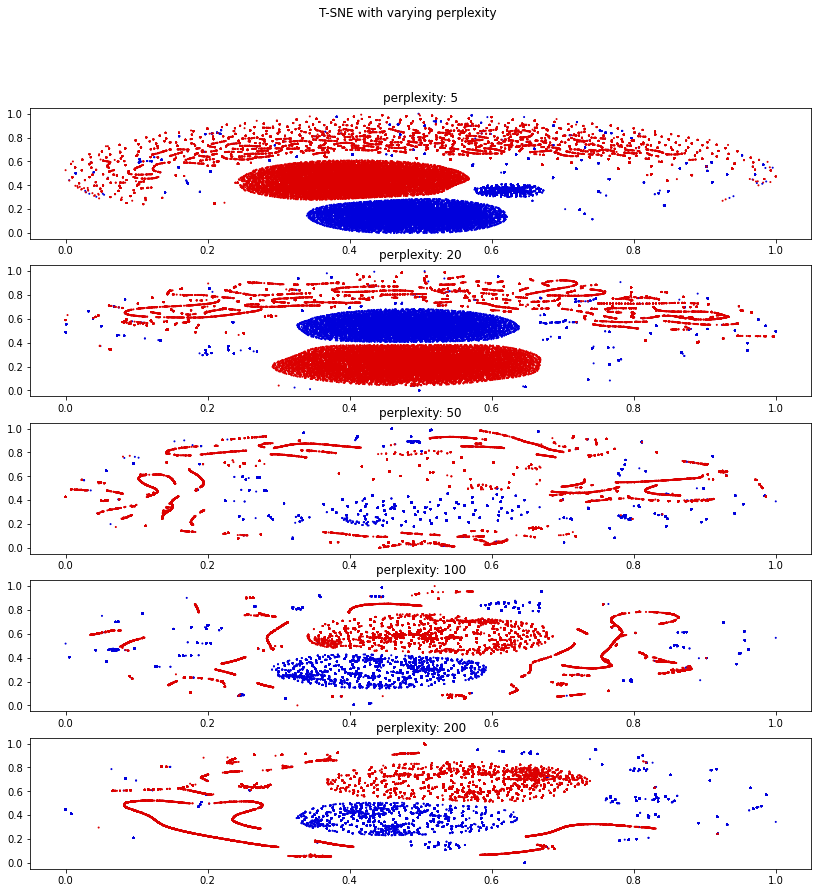

In [178]:
# initialize a matplotlib plot
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5)
fig.suptitle('T-SNE with varying perplexity')
fig.set_size_inches(14, 14)
colors=np.concatenate((Y,Y,Y), axis=1)
colors= np.where(colors==0, [0/255.0, 0/255.0, 220/255.0], [220/255.0, 0/255.0, 0/255.0])

tx, ty=compute_TSNE(perplexity[0], X)
ax0.scatter(tx, ty, c=colors, s=1)
ax0.set_title("perplexity: {}".format(perplexity[0]))

tx, ty=compute_TSNE(perplexity[1], X)
ax1.scatter(tx, ty,c=colors, s=1)
ax1.set_title("perplexity: {}".format(perplexity[1]))

tx, ty=compute_TSNE(perplexity[2], X)
ax2.scatter(tx, ty,c=colors, s=1)
ax2.set_title("perplexity: {}".format(perplexity[2]))

tx, ty=compute_TSNE(perplexity[3], X)
ax3.scatter(tx, ty,c=colors, s=1)
ax3.set_title("perplexity: {}".format(perplexity[3]))

tx, ty=compute_TSNE(perplexity[4], X)
ax4.scatter(tx, ty,c=colors, s=1)
ax4.set_title("perplexity: {}".format(perplexity[4]))

# finally, show the plot
plt.show()